# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [43]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1350


## Group Number :

## Student 1 
### Name : Martijn van Meerten
### ID : 4387902

## Student 2
### Name : Yannick Haveman
### ID : 4299078

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [3]:
# Fill in absolute path to the credit card fraud data here
data_path = "C:\\Users\Martijn.vanMeerten\workspace\studie\CDA\Lab1\data_for_student_case.csv"

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import re
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OrdinalEncoder

# Install numpy, pandas, seaborn, matplotlib, imblearn and sklearn

## 1. Visualization task – 1 A4

### 1a. Plot visulations 

In [45]:
# Read data
df1 = pd.read_csv(data_path)

# Class label 
df1 = df1.loc[~(df1['simple_journal'] == 'Refused')]
df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0

# Various feature label encoding
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)

# 4. Date
df1['creationdate'] = pd.to_datetime(df1['creationdate'])

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

# Convert country codes to the same label
unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

# Various label encodings
enc1 = LabelEncoder()
enc1.fit(df1['txvariantcode'])
df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df1['currencycode'])
df1['currencycode'] = enc2.transform(df1.currencycode)

enc3 = LabelEncoder()
enc3.fit(df1['shopperinteraction'])
df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df1['accountcode'])
df1['accountcode'] = enc4.transform(df1.accountcode)

enccc = LabelEncoder()
enccc.fit(df1['accountcode_cc'])
df1['accountcode_cc'] = enccc.transform(df1.accountcode_cc)

enc5 = LabelEncoder()
enc5.fit(df1['cardverificationcodesupplied'])
df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df1['mail_id'])
df1['mail_id'] = enc6.transform(df1.mail_id)

df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

df1['day_of_week'] = df1['creationdate'].dt.dayofweek

df1['hour'] = df1['creationdate'].dt.hour
df1['day_of_week'] = df1['creationdate'].dt.dayofweek

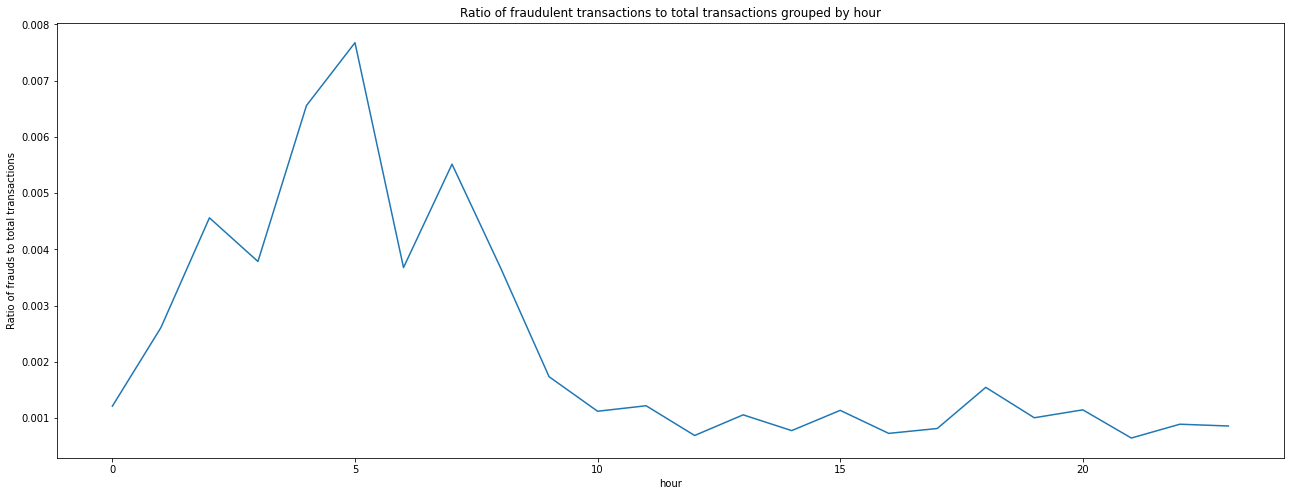

In [35]:
df2 = df1[['hour','simple_journal']].groupby(['hour']).sum()
df3 = df1[['hour', 'simple_journal']].groupby(['hour']).count()
df4 = df2 / df3
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df4.index,y=df4['simple_journal'])
ax.set(ylabel = "Ratio of frauds to total transactions")
plt.title('Ratio of fraudulent transactions to total transactions grouped by hour')
plt.show()

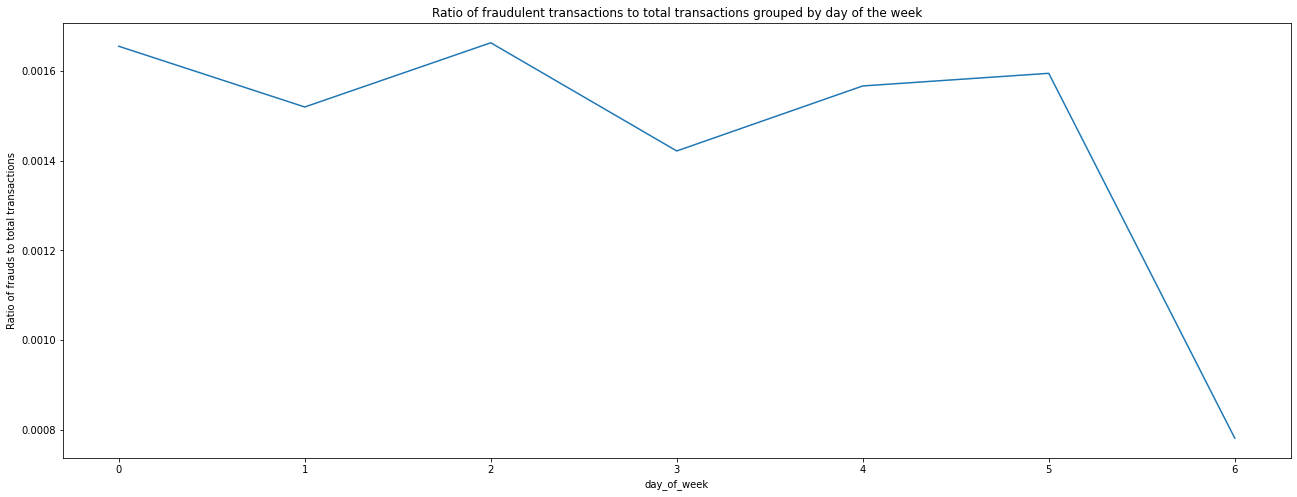

In [36]:
df2 = df1[['day_of_week','simple_journal']].groupby(['day_of_week']).sum()
df3 = df1[['day_of_week', 'simple_journal']].groupby(['day_of_week']).count()
df4 = df2 / df3
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df4.index,y=df4['simple_journal'])
ax.set(ylabel = "Ratio of frauds to total transactions")
plt.title('Ratio of fraudulent transactions to total transactions grouped by day of the week')
plt.show()

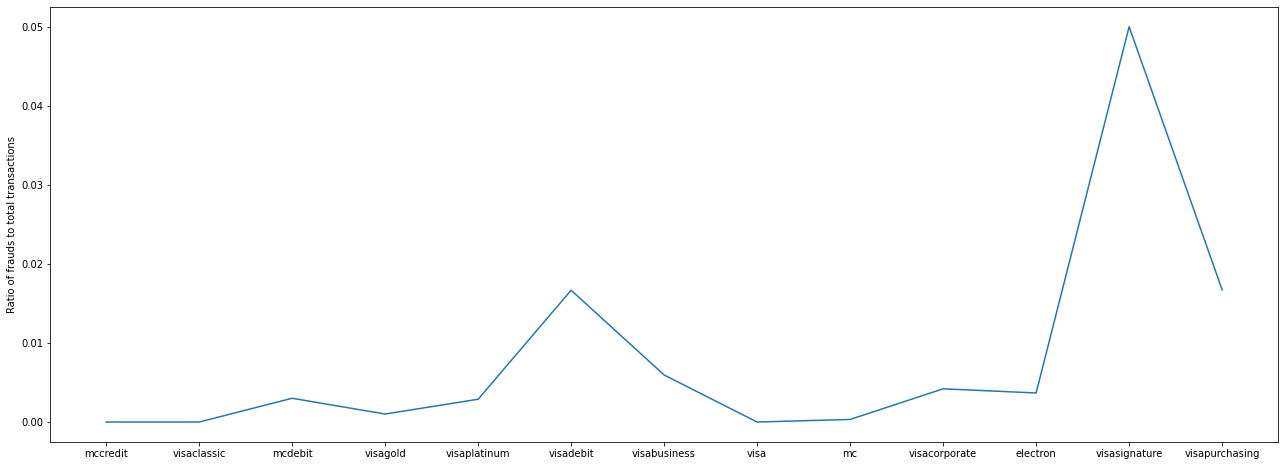

In [38]:
df2 = df1[['txvariantcode','simple_journal']].groupby(['txvariantcode']).sum()
df3 = df1[['txvariantcode','simple_journal']].groupby(['txvariantcode']).count()
df4 = df2 / df3

inv = enc1.inverse_transform(df1['txvariantcode'])
inv = list(dict.fromkeys(inv))

len(df2.loc[df2['simple_journal'] > 0])
f, (ax) = plt.subplots(1,figsize = (22, 8))

ax = sns.lineplot(x=inv,y=df4['simple_journal'])
ax.set(ylabel = "Ratio of frauds to total transactions")
plt.show()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

##### Hour
We group the data by hour and plot the ratio of frauds to total transactions. Interestingly, we find that comparatively many more frauds occur from 1 to 9. It is logical to assume that more frauds occur at night, since the total volume of transactions is larger during the day. It is however unclear from the data how different timezones are handled. Therefore, we can't make any conclusion form this plot on whether more frauds occur during the night or day.

##### Day of week
Once again we group the data, but this time per day of the week. Sunday appears to have half the ratio of frauds compared to the other days of the week. Whether this is due to there being more legitimate transactions or less fraudulent transactions is unclear, but the result is nonetheless very interesting.

##### Txvariantcode
The card type seems to have an influence on the rate of fraudulent transactions. Visasignature and visa in general seems to have relatively more fraudulent transactions than mastercard. This could also be a result of the company's policy for fraud detection and prevention and not necessarily an indicator of more actual fraud.

## 4. Classification task – 2 A4

### Preprocessing

In [46]:
# Read data
data_df = pd.read_csv(data_path)

original_data_df = data_df.copy()

# Columns to keep in the data
keep_cols = [
    "issuercountrycode",
    "txvariantcode",
    "bin",
    "amount",
    "currencycode",
    "shoppercountrycode",
    "shopperinteraction",
    "cardverificationcodesupplied",
    "cvcresponsecode",
    "accountcode",
    "creationdate",
    "mail_id",
    "ip_id",
    "card_id",
    "simple_journal"
]

df1 = data_df[keep_cols]

# Class label
df1 = df1.loc[~(df1['simple_journal'] == 'Refused')]
df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0

# Data cleanup
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

# Add column with amounts in euro
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

# One hot encode selected columns
one_hot_encode_cols = [
    "currencycode", 
    "shopperinteraction",
    "accountcode",
    "txvariantcode",
    "issuercountrycode",
    "shoppercountrycode"
]

df1 = pd.get_dummies(df1, columns=one_hot_encode_cols)

# Ordinally encode responsecode
df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3
df1.loc[df1['cvcresponsecode'] == 0, 'cvcresponsecode'] = 4
df1.loc[df1['cvcresponsecode'] == 1, 'cvcresponsecode'] = 0
df1.loc[df1['cvcresponsecode'] == 2, 'cvcresponsecode'] = 1
df1.loc[df1['cvcresponsecode'] == 4, 'cvcresponsecode'] = 2

# Various other encodings
bin_enc = LabelEncoder()
bin_enc.fit(df1['bin'])
df1['bin'] = bin_enc.transform(df1.bin)

card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'
mail_enc = LabelEncoder()
mail_enc.fit(df1['mail_id'])
df1['mail_id'] = mail_enc.transform(df1.mail_id)

# Pre-processing the creationdate to be used by the classifier
df1['creationdate'] = pd.to_datetime(df1['creationdate'])
df1['creation_month'] = df1['creationdate'].dt.month
df1['creation_week'] = df1['creationdate'].dt.isocalendar().week
df1['creation_day'] = df1['creationdate'].dt.day
df1['creation_hour'] = df1['creationdate'].dt.hour
df1['creation_minute'] = df1['creationdate'].dt.minute
df1['creation_dayofweek'] = df1['creationdate'].dt.dayofweek

# Get target
y = df1["simple_journal"].to_numpy().astype(int)
df1.drop(columns=["simple_journal", "creationdate"], inplace=True)

X = df1.to_numpy().astype(float)


### Classification

##### white-box: Naive Bayes classifier

In [14]:
n_folds = 10
k = 8
k_fold = StratifiedKFold(n_splits=n_folds)
y_white_predictions = np.zeros(len(y))
y_white_index_arrays = []
for train_index, test_index in k_fold.split(X, y):
    print("New fold")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    classifier = GaussianNB()
    classifier.fit(X_train, y_train)

    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    y_white_predictions[test_index] = y_pred_proba
    y_white_index_arrays.append(test_index)


New fold
New fold
New fold
New fold
New fold
New fold
New fold
New fold
New fold
New fold


##### Black-box: SGD classifier

In [7]:
# scale the data to 0 mean and unit variance for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_folds = 10
k = 8
k_fold = StratifiedKFold(n_splits=n_folds)
y_black_predictions = np.zeros(len(y))
y_black_index_arrays = []
for train_index, test_index in k_fold.split(X_scaled, y):
    print("New fold")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTE(random_state=1, k_neighbors=k, sampling_strategy=1)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    classifier = MLPClassifier(random_state=1, max_iter=100)
    classifier.fit(X_train, y_train)

    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    print(y_pred_proba)
    y_black_predictions[test_index] = y_pred_proba
    y_black_index_arrays.append(test_index)


New fold
[0.97955943 0.97762921 0.99925137 ... 0.92442939 0.80169245 0.70510926]
New fold
[8.20733577e-01 9.64510169e-01 8.82170464e-01 ... 3.12049521e-01
 8.13475076e-02 1.85854908e-50]
New fold
[5.38907819e-01 7.56465593e-01 7.35451800e-01 ... 4.33140567e-91
 8.65486305e-03 1.81326782e-01]
New fold
[8.27310139e-01 7.70766316e-01 8.54440288e-01 ... 8.10791060e-02
 1.57537446e-01 1.01004789e-05]
New fold
[9.22217835e-01 9.27645668e-01 9.81491530e-01 ... 1.63358085e-22
 1.82322695e-99 1.18209594e-11]
New fold
[7.99784113e-01 7.68149981e-01 9.19683823e-01 ... 2.31071727e-10
 7.32035359e-02 9.34726033e-02]
New fold
[9.44851580e-01 8.52347920e-01 9.04829241e-01 ... 6.99145101e-52
 7.77515613e-02 4.62794301e-02]
New fold
[7.75966324e-001 8.80359544e-001 9.40171859e-002 ... 1.13921302e-010
 2.09012698e-223 1.72594001e-018]
New fold
[9.32441178e-001 9.76530923e-001 1.20070361e-006 ... 2.86497216e-001
 2.63628275e-098 3.71737635e-159]
New fold
[0.78496581 0.6257403  0.7629735  ... 0.51811254 0

### 4a. Print relevant plots and metrics with clear headings.

#### True positives and false positives for optimal threshold

In [47]:
def tp_fp(y_prediction_probabilities, y, threshold):
    y_pred = np.where(y_prediction_probabilities > threshold, 1, 0)
    true_positive_count = sum(a == 1 and b == 1 for a, b in zip(y_pred, y))
    false_positive_count = sum(a == 1 and b == 0 for a, b in zip(y_pred, y))
    print("True positives: " + str(true_positive_count))
    print("False positives: " + str(false_positive_count))
    
print("White box:")
tp_fp(y_white_predictions, y, 0.99)
print("Black box:")
tp_fp(y_black_predictions, y, 0.999)

White box:
True positives: 44
False positives: 4044
Black box:
True positives: 36
False positives: 3850


#### Precision, recall, fscore

In [48]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def precision_recall_fscore(y, y_pred, average):
    precision = precision_score(y, y_pred, average=average)
    recall = recall_score(y, y_pred, average=average)
    fscore = f1_score(y, y_pred, average=average)
    return (precision, recall, fscore)

print("White-box:" + str(precision_recall_fscore(y, np.where(y_white_predictions > 0.99, 1, 0), 'binary')))
print("Black-box: " + str(precision_recall_fscore(y, np.where(y_black_predictions > 0.999, 1, 0), 'binary')))


White-box:(0.010763209393346379, 0.12753623188405797, 0.01985111662531017)
Black-box: (0.009264024704065878, 0.10434782608695652, 0.017017253604348855)


#### Roc curves for the 10 folds

In [49]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# Plot the ROC curves of all folds and their vertically averaged curve and std
def plot_roc(y_predictions, y_index_arrays, title):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # Go through all folds
    for test_index in y_index_arrays:
        y_pred = y_predictions[test_index]
        y_test = y[test_index]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, alpha=.3)
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    # Calculate mean
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

    # Calculate std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.2)

    plt.legend(loc="lower right")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot([0, 1], [0, 1], c="gray", linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(title)
    plt.show()
    
# Plot the mean roc curves of both white- and black-box classifiers
def plot_mean_roc(y_predictions, y_index_arrays):
    k = 5
    n_folds = 5
    colors = ['blue', 'red']
    classifier_names = ['Naive Bayes', 'MLP']

    for i in range(2):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for test_index in y_index_arrays[i]:
            y_pred = y_predictions[i][test_index]
            y_test = y[test_index]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, label=r'Mean ROC %s (AUC = %0.2f $\pm$ %0.2f)' % (classifier_names[i], mean_auc, std_auc), color=colors[i])

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[i], alpha=.2)

    plt.legend(loc="lower right")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("Vertically averaged ROC curves for naive bayse and MLP")
    plt.plot([0, 1], [0, 1], c="gray", linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

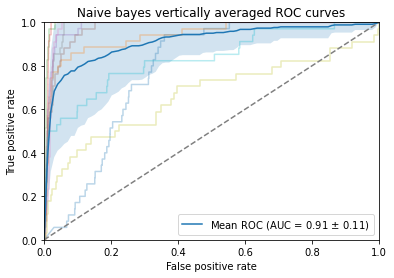

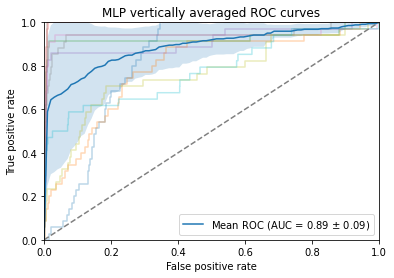

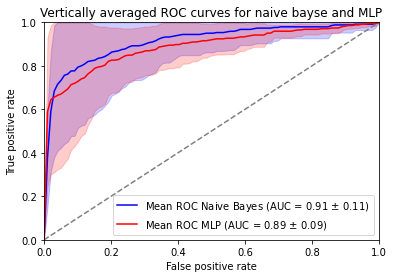

In [32]:
plot_roc(y_white_predictions, y_white_index_arrays, "Naive bayes vertically averaged ROC curves")
plot_roc(y_black_predictions, y_white_index_arrays, "MLP vertically averaged ROC curves")
plot_mean_roc([y_white_predictions, y_black_predictions], [y_white_index_arrays, y_black_index_arrays])

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

### Pre-processing
Before training any classifier, the data needs to be processed in order for the classifier to be able to work with data. We remove several columns that can be considered cheating or columns/values that reduce the performance of the classifier. 
- bookingdate: We remove bookingdate as keeping this information gives the classifier information that it will not have in a real-world situation. The bookingdate is only applied after determining whether a transaction is fraudulent. Bookingdates for chargeback transactions are much later than creation date, while for settled transactions this is only a few days.
- txid: We remove txid, because it is very simple to determine simple_journal value from this data. The different values of simple_journal are clustered around consecutive txids. Therefore, the classifier will use this information to easily determine simple_journal, which is unrealistic in a real-world scenario.
- simple_journal=refused: We remove all transactions that are refused, because transactions with this value can be either fraudulent or not fraudulent. Assigning this data to either category will reduce the quality of the dataset, because it will include points from the opposite classification, causing the classifier to train on wrong data.

The categorical features of the dataset need to be encoded in order to be used by the classifiers. Below we give our motivation for the type of encoding used for each feature.
- currencycode, shopperinteraction, accountcode, txvariantcode, issuercountry, shoppercountrycode: One-hot encoding because there is no natural ordering in countries and currencies and the number of unique values for the first three is small
- ip_id, card_id, mail_id: ordinal encoding because even though there is no natural ordering in the values, the number of unique values is large and would therefore explode the number of features.
- cvcresponsecode: ordinal encoding because the values have natural ordering. From least probability of fraud to most (1 -> 0 -> 3-6 -> 2)

The creationdate values are transformed into columns for: month, week, day, minute and dayofweek. The classifiers are unable to work with dates as is, therefore splitting the values still allows the classifier to work with the data.

### Algorithms
#### White-box
For the white-box classifier we use naive bayes. It is a simple classifier but performs well in many situations. The data for naive bayes is not SMOTEd, because naive bayes is a generative model. It models the joint probability distribution of the features and the target instead of the probability distribution of the target given the features. Generating new samples skews the probability distribution and worsens the performance slighty. Naive bayes assumes the features of the data to be independent, which is most likely not true for the credit card fraud dataset. This effect, however, is quite minimal and the performance of the classifier is reasonable.

#### Black-box
For the black-box classifier we use a multi-layer perceptron. This model optimizes the log-loss function using stochastic gradient descent. Before training we scale the data to 0 mean and unit variance for increased performance. We have tried several different classifiers such as random forest, SVM, linearSVC, all of which performed poorly and took a very long time. Applying a grid-search for the parameters will most likely greatly increase the performance of the classifier, but considering the duration of running MLP this is out of the scope for this assignment.

### Performance comparison
We compare the classifiers in the following metrics: ROC curves, auc, true positives, false positives, precision and recall. Given the domain of credit card fraud detection the most important metric for a good classifier is the number of false positives, since every false positive has a high cost associated to it, while still capturing many true positives. ROC curves show the number of true positives and false positives over different threshold values. One of the benefits of this metric compared to many others is that it is insensitive to skewed class distribution, which is the case for this dataset. AUC is the area under the ROC curve and therefore reduces the curve down to one score. Precision is a metric for showing the ratio of true positives to false positives and captures the goal of the classifier for this domain in one score. Recall is the number of true positives over total positives.

Setting the naive bayes classifier threshold at 0.99 gives 44 true positives and 4044 false positives, resulting in a precision of 0.0107 and recall of 0.1275.
Setting the MLP classifier threshold at 0.999 gives 36 true positives and 3850 false positives, resulting in a precision of 0.0093 and recall of 0.1043. In this case naive bayes outperforms MLP, but this will most likely change after parameter tuning of MLP.

### White-box explanation
The Naive Bayes model is seen as a White-Box classifier as the classifications done by the model are explainable. Naive bayes calculates a joint probability distribution over the features and the targets. The decision can be explained by looking at the model's interior probability distribution and one can then make claims in the form of: "Given feature x, prior data shows us that the target label is more likely to be y". In theory, one is able to do all the calculations by hand and should then arrive at the same results provided for by the model.


## 5. Bonus task – 1 A4

### 5a. Provide code and report below